# Sinkhorn Divergence Hessians

In this tutorial, we showcase the ability of `OTT` to differentiate automatically its outputs. We highlight this by computing the Hessian of the {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence` w.r.t. either weights `a` of the input measure, or locations `x`. Two approaches can be used to do so: rely on `JAX` native handling of computational graphs, or by using instead implicit differentiation of the solutions computed by `OTT`. In the example below we show that they are equivalent, but note this may not always be the case.

In [1]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.solvers.linear import implicit_differentiation as imp_diff
from ott.tools import sinkhorn_divergence

In [2]:
def sample(n: int, m: int, dim: int):
    """Sample points and random perturbation directions."""
    rngs = jax.random.split(jax.random.PRNGKey(0), 7)
    x = jax.random.uniform(rngs[0], (n, dim))
    y = jax.random.uniform(rngs[1], (m, dim))
    a = jax.random.uniform(rngs[2], (n,)) + 0.1
    b = jax.random.uniform(rngs[3], (m,)) + 0.1
    a = a / jnp.sum(a)
    b = b / jnp.sum(b)
    delta_a = jax.random.uniform(rngs[5], (n,)) - 0.5
    delta_a = delta_a - jnp.mean(delta_a)  # sums to 0.
    delta_x = jax.random.uniform(rngs[6], (n, dim)) - 0.5

    return a, x, b, y, delta_a, delta_x

Sample two random 3-dimensional point clouds and their perturbations.

In [3]:
a, x, b, y, delta_a, delta_x = sample(17, 15, 3)

As usual in JAX, we define a custom loss that outputs the quantity of interest, and is defined using relevant inputs as arguments, i.e. parameters against which we may want to differentiate. We add to `a` and `x` the `implicit` auxiliary flag which will be used to switch between unrolling and implicit differentiation of the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm (see this excellent [tutorial](http://implicit-layers-tutorial.org/implicit_functions/) for a deep dive on their differences).

The loss outputs the Sinkhorn divergence between two {class}`point clouds <ott.geometry.pointcloud.PointCloud>`.

In [4]:
def loss(a: jnp.ndarray, x: jnp.ndarray, implicit: bool = True) -> float:
    return sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud,
        x,
        y,  # this part defines geometry
        a=a,
        b=b,  # this sets weights
        sinkhorn_kwargs={
            "implicit_diff": imp_diff.ImplicitDiff() if implicit else None,
            "use_danskin": False,
        },
    ).divergence

Let's parse the above call to {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence` above:

- The first three lines define the point cloud geometry between `x` and `y` that will define the cost matrix. Here we could have added details on `epsilon` regularization (or scheduler), as well as alternative definitions of the cost function (here assumed by default to be squared Euclidean distance). We stick to the default setting.

- The next two lines set the respective weight vectors `a` and `b`. Those are simply two histograms of size `n` and `m`, both sum to $1$, in the so-called balanced setting.

- Lastly, `sinkhorn_kwargs` pass arguments to three {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` solvers that will be called to compare `x` with `y`, `x` with `x` and `y` with `y` with their respective weights `a` and `b`. Rather than focusing on the several numerical options available to parameterize {class}`~ott.solvers.linear.sinkhorn.Sinkhorn`'s behavior, we instruct `JAX` on how it should differentiate the outputs of the Sinkhorn algorithm. The `use_danskin` flag specifies whether the outputted potentials should be frozen when differentiating. Since we aim for second-order differentiation here, we must set this to `False` (if we wanted to compute gradients, `True` would have resulted in faster yet almost equivalent computations).

## Computing Hessians

Let's now plot Hessians of this output w.r.t. either `a` or `x`. 

- The Hessian w.r.t. `a` will be a $n \times n$ matrix, with the convention that `a` has size $n$. Note that this Hessian matrix should be, in principle, positive definite. This is a property we check numerically.
- Because `x` is itself a matrix of 3D coordinates, the Hessian w.r.t. `x` will be a 4D tensor of size $n \times 3 \times n \times 3$.

To plot both Hessians, we loop on `arg` $0$ (corresponding to `a`) or $1$ (corresponding to `x`) of `loss`, and plot all (or part, for `x`) of those Hessian operators, to check they match. We only plot a thin $n\times 3$  slice of the 4D tensor for `x`. We also check numerically that these Hessian operators are sound when compared to a finite difference approximation applied on an arbitrary direction.

Derivation w.r.t. weights `a`
---- Time: Unrolled Hessian
1.99 ms ± 92.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Min | Max eigenvalues of Hessian- Unrolled   9.099584e-07  |  3.53894
---- Time: Implicit Hessian
2.38 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Min | Max eigenvalues of Hessian- Implicit   -2.0220386e-07  |  3.539016
---- Hessian quadratic form at random perturbation
Unrolled Diff. :0.9277187
Implicit Diff. :0.9277266
Finite Diff. : 0.9536743 

Derivation w.r.t. locations `x`
---- Time: Unrolled Hessian
8.48 ms ± 82.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
---- Time: Implicit Hessian
7.13 ms ± 205 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
---- Hessian quadratic form at random perturbation
Unrolled Diff. :-0.21479894
Implicit Diff. :-0.21479797
Finite Diff. : -0.23841858 



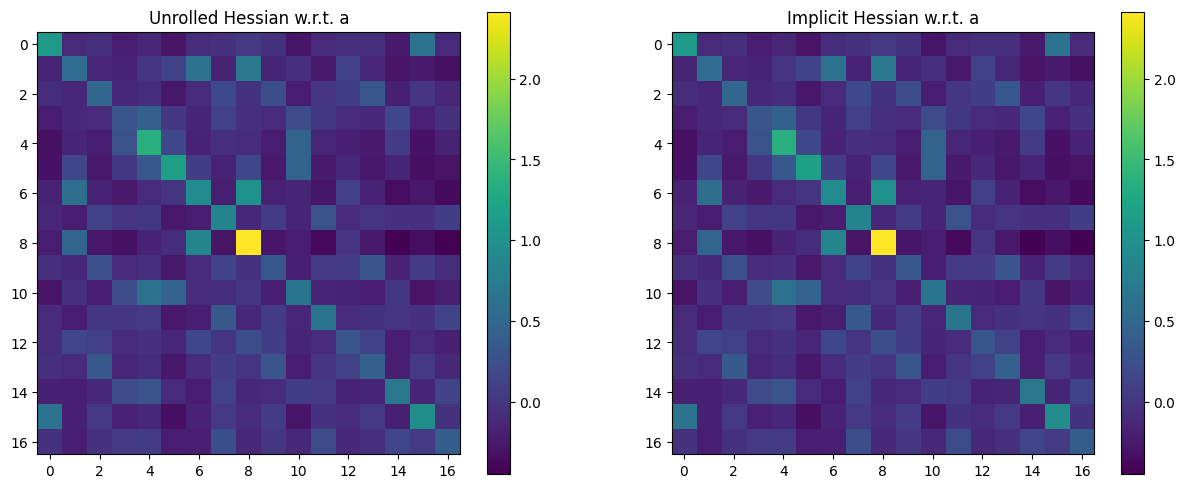

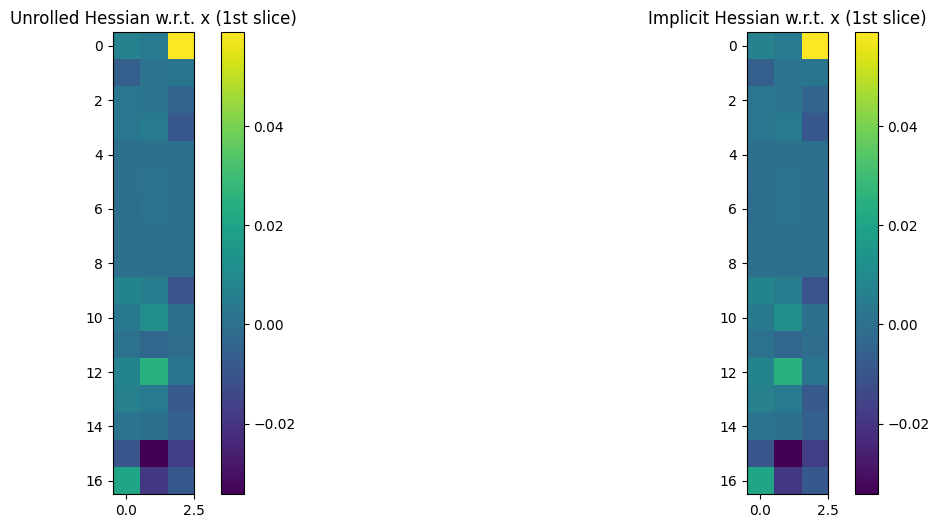

In [5]:
# Loop over differentiating w.r.t. weights `a` or locations `x`.
for arg in [0, 1]:
    print(
        "Derivation w.r.t. " + ("weights `a`" if arg == 0 else "locations `x`")
    )
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    # Materialize Hessians using either implicit or unrolling.
    hessians = {}
    methods = ("Unrolled", "Implicit")
    for imp, method, axs in zip((False, True), methods, (ax1, ax2)):
        hess_loss = jax.jit(
            jax.hessian(lambda a, x: loss(a, x, imp), argnums=arg)
        )
        print("---- Time: " + method + " Hessian")
        %timeit _ = hess_loss(a, x).block_until_ready()
        hess = hess_loss(a, x)
        if arg == 0:
            # Because the OT problem is balanced, Hessians w.r.t. weights are
            # only defined up to the orthogonal space of 1s.
            # For that reason we remove that contribution to compare the properties
            # of these matrices.
            hess -= jnp.mean(hess, axis=1)[:, None]

            # We now look into their eigenvalues to check they are all nonnegative.
            eigenvalues = jnp.real(jnp.linalg.eig(hess)[0])
            e_min, e_max = jnp.min(eigenvalues), jnp.max(eigenvalues)
            print(
                "Min | Max eigenvalues of Hessian-",
                method,
                " ",
                e_min,
                " | ",
                e_max,
            )

        # Plot Hessian Matrix (or 2D slice if 4D tensor)
        im = axs.imshow(hess if arg == 0 else hess[0, 0, :, :])
        axs.set_title(
            method + " Hessian w.r.t. " + ("a" if arg == 0 else "x (1st slice)")
        )
        fig.colorbar(im, ax=axs)
        hessians[method] = hess

    # Comparison with Finite differences
    delta = delta_x if arg else delta_a

    # Compute <delta, H delta> where H is either unrolled/implicit Hessian
    diffs = {}
    for method, hess_mat in hessians.items():
        if arg == 0:
            h_d = hess_mat @ delta
        else:
            h_d = jnp.tensordot(hess_mat, delta)
        diffs[method] = jnp.sum(delta * h_d)

    # Approx <delta, H delta> using finite differences.
    a_p, a_m, x_p, x_m = a, a, x, x
    perturb_scale = 1e-3
    if arg == 0:
        a_p = a + perturb_scale * delta
        a_m = a - perturb_scale * delta
    else:
        x_p = x + perturb_scale * delta
        x_m = x - perturb_scale * delta

    app_p = loss(a_p, x_p)
    app_m = loss(a_m, x_m)
    fin_dif = (app_p + app_m - 2 * loss(a, x)) / (perturb_scale**2)

    # Print them to check they are relatively close.
    print("---- Hessian quadratic form at random perturbation")
    for m in methods:
        print(m + " Diff. :" + str(diffs[m]))
    print("Finite Diff. :", fin_dif, "\n")